## Introduction to classifiers
So far, we have focussed on a regression task, i.e. predicting a continuous value based on the data.
This is one of two broad components of supervised machine learning.

We will spend the rest of this session and the start of next look at classifiers, which follow many of the same principels, but predict a label instead of a value for the data

As a toy dataset, we will use MNIST, a very popular set of 70,000 handwritten digits.  Each image is a set of monochromatic
pixels (the data) and the label is the corresponding digit.  Our task will be to find an algorithm that can learn from patterns
in the pixel data to predict the identity of the digit.

Many of the techniques we introduce here transfer to machine learning fields like medical imaging

In [21]:
import numpy as np
# load the dataset
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [25]:
# segment the set into data and labels
X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)
y = y.astype(np.uint8)

(70000, 784)
(70000,)


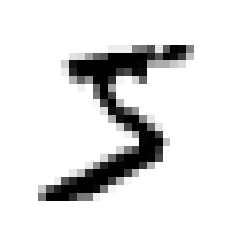

In [26]:
# Let's look briefly at what we're working with

import matplotlib.pyplot as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")

plt.show()



Let's train some models.  We'll start with a binary classification task i.e. predict whether each image is/isn't a 5, and we can work up to multiclass classification
i.e. predicting the actual class the digit belongs to.

### The SGD Classifier

SKlearn implements the SGDclassifier which we will use in the first instance.  Instead of wrapping a particular algorithm it can make use of several linear models that it chooses based on the problem (more on this later).  It also uses stochastic gradient descent, a slightly faster version of batch gradient descent which I introduced last time.  Useful when you have a large training set and limited patience!

In [27]:
from sklearn.linear_model import SGDClassifier

# the data comes pre split into a 9:1 train:test ratio
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

print(y_train)

# Get the binary classes for the train and test set labels
y_train_5 = (y_train == 5) # true for 5s, false for anything else
y_test_5 = (y_test == 5)

print(y_train_5)
sgd_clf = SGDClassifier()
sgd_clf.fit(X_train, y_train_5)

sgd_clf.predict([some_digit])


[5 0 4 ... 5 6 8]
[ True False False ...  True False False]


array([ True])

As we did previously, we can use cross validation to get an idea of whether out model is overfitting to the training set.

We'll use the 'accuracy' metric as the criteria, which is just the proportion of predictions that are in the correct class vs incorrect

In [28]:
from sklearn.model_selection import cross_val_score
# note the change of scoring metric from MSE to accuracy
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')


array([0.9547 , 0.9485 , 0.94335])

### The problem with accuracy

It would appear that we've trained a pretty good model here, with ~95% accuracy!

Like I said last time, you should treat a model that performs extremely well with skepticism until you can prove that is
is not simply overfitting!. As you might expect, ~90% of the training data is not a 5, so I
could write a 'classifier' that just blindly predicts False, and it would return 90% accuracy on my training set!
Accuracy (ratio of correct/incorrect predictions) is not such a great metric for classifiers, which is only worse when you have skewed datasets.



In [32]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
    
never_5_classifier = Never5Classifier()
cross_val_score(never_5_classifier, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

### Confusion matrices and ROC score

SKlearn provides some really useful tools to let us deal with determining classifier performace

What if, instead of looking at the proportion that the classifier got right, we focus on the numbers that were mislabelled as well?

A confusion matrix allows us to visualise this, it gives us a grid of true/false positive/negative results, like this:

    TN  FP
    FN  TP

In [33]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
# let's get some predictions from the cross validation function, trained to predict just the 5s
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
confusion_matrix(y_train_5, y_train_pred)


array([[52995,  1584],
       [ 1270,  4151]])


## Introduction to precision and recall

The confusion matrix gives us the idea of true and false positive and negative, but we can go further: we can calculate the two most important metrics when determining classifier performance: precision and
recall.
The combination of these two metrics captures the overall performance of your classifier.  They are calculated in the following way

$$ precision = \frac{TP}{FP + TP} $$

$$ recall = \frac{TP}{TP + FN} $$

I like to think about this with idea of a decision boundary:

The tighter the circle gets around the cluster of red points, the fewer blue points are going to get caught (lower false positives, your precision increases),
however you're also going to miss some red points that now lie outside the circle (your false negatives increase), so you have a precision-recall trade off

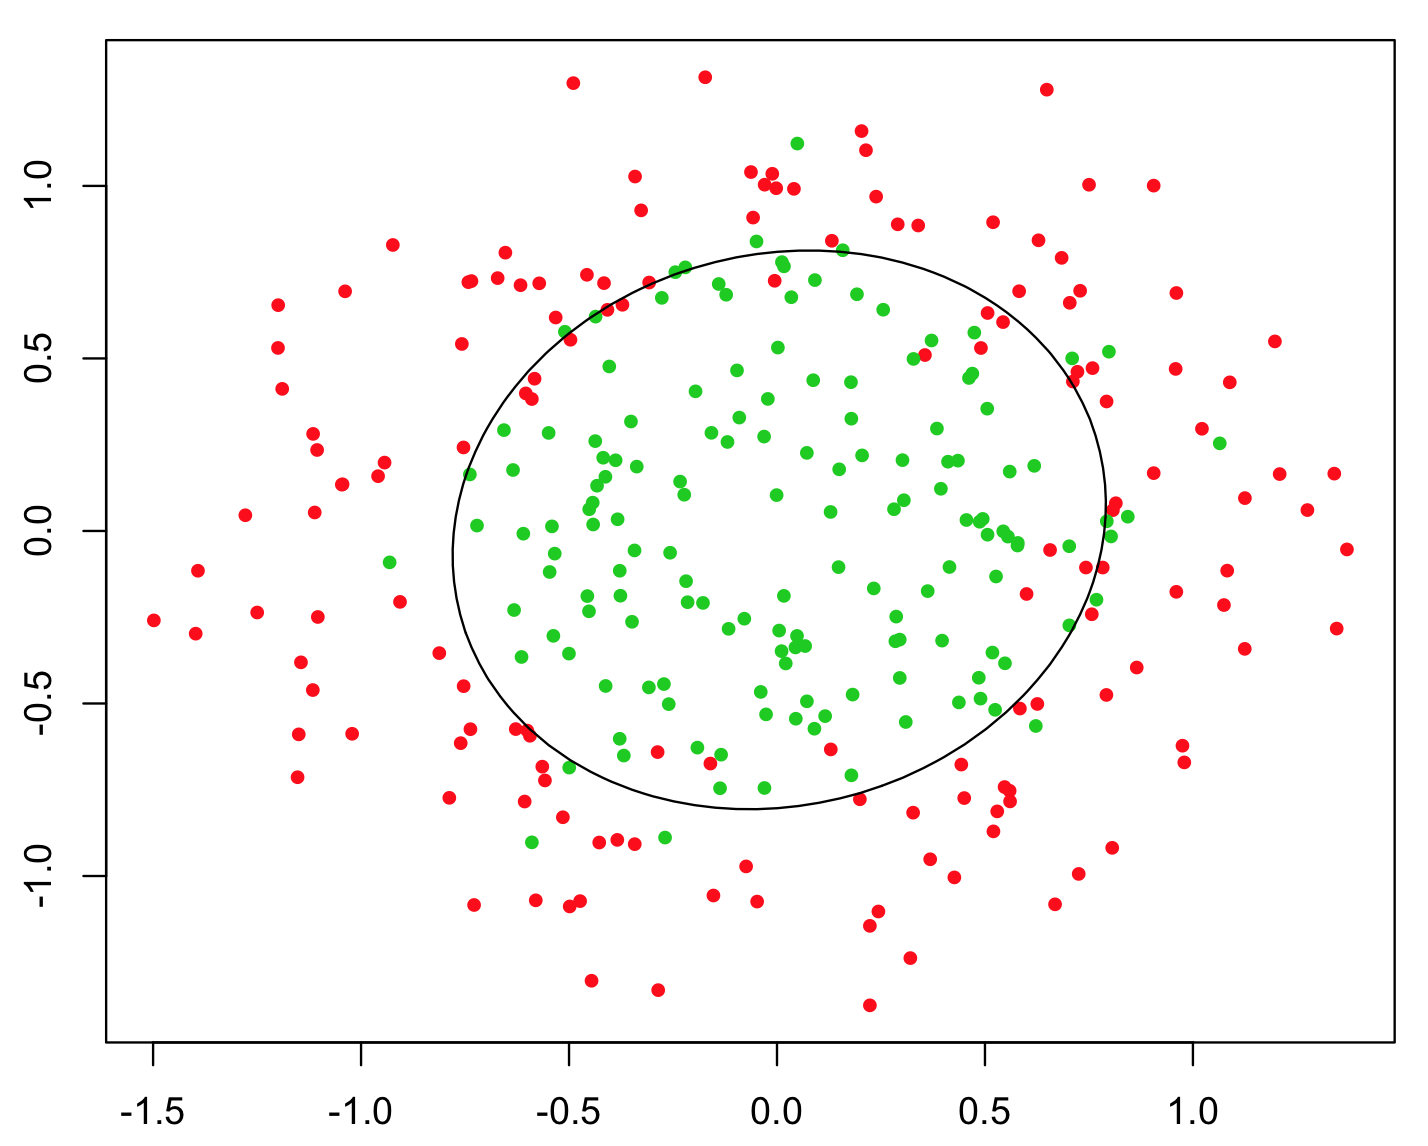

We can get SKlearn to calculate these metrics for us based on the classifier data



In [37]:
from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_train_5, y_train_pred)
recall = recall_score(y_train_5, y_train_pred)

print(f"precision score: {precision}\nrecall score: {recall}")




precision score: 0.7238012205754141
recall score: 0.7657258808337944


In [38]:
# let's run the same as before, but using "decision function" will return the decision scores instead of absolute predictions
# this gives us an idea of how confident the model is in its prediction
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

Let's visualise what this precision recall trade off looks like in a couple of different ways

In [39]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

We can look at how precion and recall vary with the decision threshold we chose

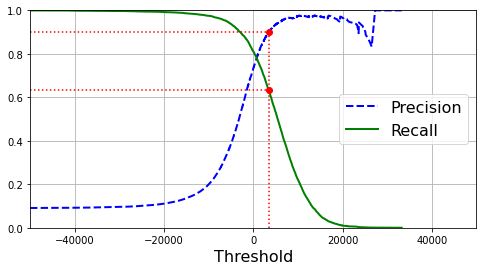

In [40]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)
    plt.grid(True)
    plt.axis([-50000, 50000, 0, 1])



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")                                             
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             
plt.show()


We can also look at how the precision and recall are correlated with each other...

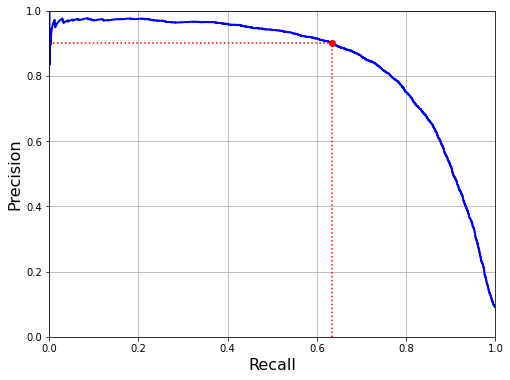

In [41]:
# useful plot to visualise the performance of your classifier is precision vs recall

def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
plt.show()

## ROC curve

One more tool to introduce you to is the ROC curve - a very common metric for conveying how well your classifier is performing in a single graph

It is very similar to what we've plotted above, except that instead of plotting precision vs recall, it plots the TPR (recall) against the false positive rate.  Ideally you want to maximise your TPR whilst minimising FPR

This has a straightforward interpretation in terms of the area under the curve.  It the classifier was randomly guessing, you would expect $$ FPR == TPR $$

Anything with an area > 0.5 is providing some kind of enrichment. You want to get you recall as far into the top left corner before the FPR starts to increase to give you maximum predictive performance.



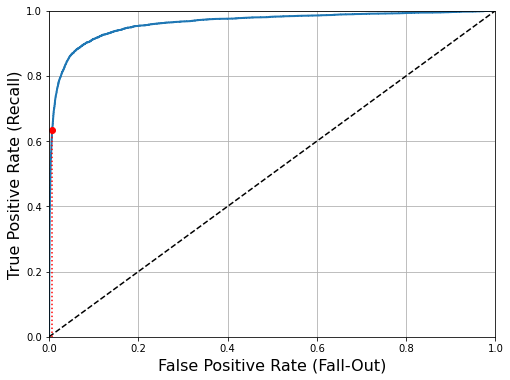

In [42]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.show()


In [43]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)



0.962176855896355

### Exercise set 1: calculate the ROC curve for a more powerful model and compare to the model we just trained

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# 1) Define a RandomForest classifier and train it on the dataset using cross validation

# 2) use the functions provided above to calculate the ROC AUC for your classifier and compare to the linear model
# Note: remember to use the "decision function" method on your Cross validation run

## Introducing some more classification algorithms

Now that we have an introduction to binary classification, let's think about how we could expand it to the more general case of multiclass classification e.g. the 10 classes
we want to use for our digit detection algorithm.

We have a few strategies we could use here -
* The one-vs-all strategy, where we train n binary classifiers to detect whether or not the digit
is a 0, 1, 2 etc, or...
* The one-vs-one strategy, where you train binary classifiers on every pair of digits and see which digit comes out as the most probably class overall
    * This is really useful for algorithms that scale poorly with training data size, since each classifier needs to be trained only on a fraction of the training data for those classes that it cares about
* Alternatively, we can chose an algorithm that supports multiclass classification "out of the box".  (if you want some further reading/thought, think about
why a svm is intrinsically a binary-only classifier, whilst others, e.g. random forest classifier, logistic regression) can handle multiple classes natively

If this seems a bit complicated, don't worry, it turns out SKlearn automatically works out which case we're going for and runs the algorithm you want
with an appropriate implementation

Which method you choose depends on a couple of factors, and you might find you get very different performance between the two methods.

Let's start with the one-vs-one method, for the support vector machine algorithm:


In [44]:

from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000]) # y_train, not y_train_5
svm_clf.predict([some_digit])


array([5], dtype=uint8)

If this doesn't look like a lot of code to train 45 classifiers (N*(N-1)/2), don't worry, that's SKlearn doing everything
for us behind the scenes!

In [45]:
# this is the raw outout from the classifier, representing the probability of each class
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

In [46]:
# we just take the argmax across the vector to calculate the most probably class
np.argmax(some_digit_scores)

5

In [47]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [48]:
svm_clf.classes_[5]


5

### Example one vs rest classifier
If we want to tell SKlearn to explicitly use a specific method instead of inferring it, we can wrap our model in the OneVsRestClassifier class
In this case we can use the SVC and simply pass it to the init method of the OvR class.


In [49]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [50]:
# check how many classses we get out
len(ovr_clf.estimators_)

10

### Exercise set 2:
Train an SGD classifier on the whole dataset, so it outputs probabilities over 10 classes

In [ ]:
from sklearn.linear_model import SGDClassifier

# 1) fit the model to the FULL training set

# 2) predict the class for the digit we extracted earlier ('some_digit')

# 3) use cross val score using the accuracy metric to see how the model performs on the whole dataset

You should have seen that your model gets ~85% accuracy on the cross validation, pretty good!
One quick way to get a bit more preformance out is to simply scale the pixel values to be in the same range.  This helps the gradient descent algorithm (see last week)
to converge more quickly on the global minimum of the loss function


In [58]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

/home/kmzp800/.conda/envs/PyTorchEnv/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


array([0.89895, 0.88725, 0.9047 ])

### Error analysis for our trained classifier

Below is the confusion matrix for the multiclass classifier.  Reassuringly most of the values lie on its principle diagonal, meaning it got the classes correct. Predicted on the top, actual on the side

In [59]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

/home/kmzp800/.conda/envs/PyTorchEnv/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/home/kmzp800/.conda/envs/PyTorchEnv/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


array([[5588,    0,   23,    5,    9,   55,   37,    6,  199,    1],
       [   0, 6405,   36,   24,    4,   47,    4,    7,  203,   12],
       [  28,   27, 5250,   92,   73,   26,   69,   39,  344,   10],
       [  23,   18,  119, 5244,    2,  221,   27,   40,  368,   69],
       [  11,   14,   47,   13, 5213,   13,   36,   25,  300,  170],
       [  28,   15,   28,  172,   54, 4508,   75,   15,  467,   59],
       [  29,   16,   42,    2,   42,  100, 5566,    3,  117,    1],
       [  20,   11,   53,   30,   50,   14,    3, 5707,  167,  210],
       [  19,   63,   46,   93,    3,  133,   26,   11, 5412,   45],
       [  25,   18,   31,   66,  121,   41,    1,  183,  326, 5137]])

In [60]:
# since sklearn 0.22, you can use sklearn.metrics.plot_confusion_matrix()
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

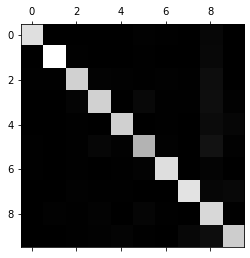

In [61]:
# let's visualise it as a colourmap so it's easier to interpret
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

When we look interpret it as a colour map, it looks pretty reassuring, indeed most of the examples have been correctly classified.

Let's visualise the errors by removing the correct entries and set the principle diagonals to zero

In [62]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

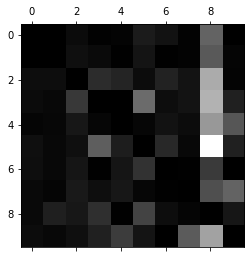

In [63]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()



This gives us a much better idea of the kind of mistakes the classifier makes - in this case it tends to predict lots of different things are misclassified as an 8.  

We can also see that 3s and 5s tend to get misclassified as each other (hence the symmetrical components)

In [64]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Here I've plotted on the left hand side images classified as 3s and on the right, images classified as 5s, so we can see where the classifier is getting confused!

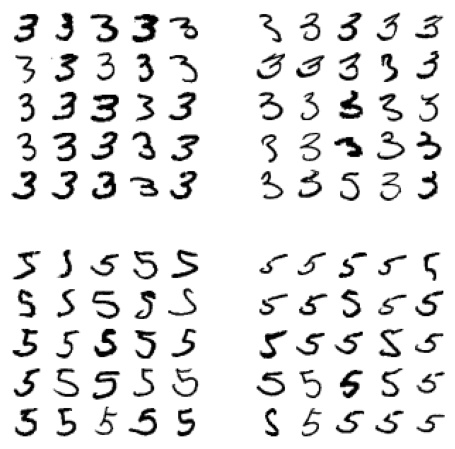

In [67]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()


### Exercise set 3

We have managed to construct a classifier that manages ~85% accuracy over the test set, but what if I told you that we chould achieve 97%?

In the code cell below, fit a KNeighboursClassifier to the data.  You may need to explore hyperparameter optimisation to get the best performance out of your model, so look at the grid search code we used last time for reference!

In [51]:
from sklearn.neighbors import KNeighborsClassifier


### Extra Reading + Exercises


### Let's go deeper into some of the algorithms commonly used for classification tasks

### Logistic Regression
Last week we met linear regression, which fits a linear function to our dataset.  I mentioned that it serves as the 'baseline' a lot of the time when you
start with a regression problem

We have an equivalent for classification tasks - Logistic regression (confusing name aside!).  It follows the same approach for the linear regression model, but it applies a <i>sigmoid</i> function
to the final output from the regression model.

So what does the softmax function do that magically turns it into a classifier?

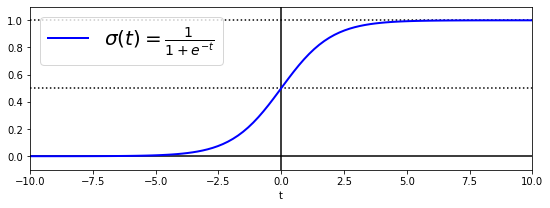

In [52]:
# This plots the sigmoid (logistic) function for us

t = np.linspace(-10, 10, 100)
sig = 1 / (1 + np.exp(-t))
plt.figure(figsize=(9, 3))
plt.plot([-10, 10], [0, 0], "k-")
plt.plot([-10, 10], [0.5, 0.5], "k:")
plt.plot([-10, 10], [1, 1], "k:")
plt.plot([0, 0], [-1.1, 1.1], "k-")
plt.plot(t, sig, "b-", linewidth=2, label=r"$\sigma(t) = \frac{1}{1 + e^{-t}}$")
plt.xlabel("t")
plt.legend(loc="upper left", fontsize=20)
plt.axis([-10, 10, -0.1, 1.1])
plt.show()

We end up transforming our output values onto the range [0,1], and we say that evaluates to >= 0.5 is class 1, else class 0.  Hence we have a binary classifier!


In [53]:
from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename']

In [54]:
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [55]:
X = iris["data"][:, 3:]  # petal width
y = (iris["target"] == 2).astype(np.int)  # 1 if Iris virginica, else 0


In [56]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(solver="lbfgs", random_state=42)
log_reg.fit(X, y)


LogisticRegression(random_state=42)

/home/kmzp800/.conda/envs/PyTorchEnv/lib/python3.8/site-packages/matplotlib/patches.py:1387: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  verts = np.dot(coords, M) + (x + dx, y + dy)


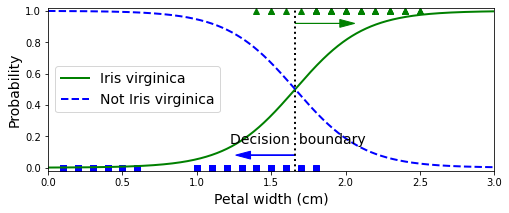

In [57]:
#let's visualise the predictions
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0]

plt.figure(figsize=(8, 3))
plt.plot(X[y==0], y[y==0], "bs")
plt.plot(X[y==1], y[y==1], "g^")
plt.plot([decision_boundary, decision_boundary], [-1, 2], "k:", linewidth=2)
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris virginica")
plt.text(decision_boundary+0.02, 0.15, "Decision  boundary", fontsize=14, color="k", ha="center")
plt.arrow(decision_boundary, 0.08, -0.3, 0, head_width=0.05, head_length=0.1, fc='b', ec='b')
plt.arrow(decision_boundary, 0.92, 0.3, 0, head_width=0.05, head_length=0.1, fc='g', ec='g')
plt.xlabel("Petal width (cm)", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 3, -0.02, 1.02])
plt.show()